**Linear Regression using Angle Embedding and Single Qubit with qml.qnn.KerasLayer**

Created by Hemant Gahankari , hemant.gahankari@gmail.com

This example is created to explain how to create a Hybrid Neural Network (Mix of Classical and Quantum Layer) and train it. 

The data set consists of a temprature readings in Degree Centigrade and corresponding Fahrenheit. 

Objective is to train a neural network to predict Fahrenheit value given Deg Centigrade value.


In [ ]:
!pip install keras-metrics

In [ ]:
!pip install pennylane

     |████████████████████████████████| 409kB 2.7MB/s 


Here we are creating a single Qubit to represent one feature and encoding it using AngleEmbedding Template. First we create device, then qnode. In qnode we have a quantum function , where in we accept inputs on one wire (qubit) in thsi case.

StronglyEntanglingLayers allows us to train Quantum Layer using parameters. Keras will create weights and pass it to our qnode and in turn to StronglyEntanglingLayers. A single StronglyEntanglingLayers can have multiple repeated layers. Each layer has three trainiable parameters that can be adjusted. The shape of the weights is hence [layers, no of qubits, 3]. 

For predicted output we use single neuron Dense Layer with linear activation.

Since we have a linear regression problem selected loss type  is mean squared error.

In [ ]:
import pennylane as qml
import tensorflow as tf
import numpy as np

import keras_metrics
import matplotlib.pyplot as plt

n_qubits = 1
layers = 3
data_dimension = 1
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


weight_shapes = {"weights": (layers, n_qubits,3)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
clayer1 = tf.keras.layers.Dense(n_qubits, activation='relu')
clayer2 = tf.keras.layers.Dense(data_dimension, activation="linear")
model = tf.keras.models.Sequential([clayer1,qlayer,clayer2])

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(opt, loss='mse')

We create a very simple dataset here and normalise it.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = np.array([0, 8, 15, 22,  38],  dtype=np.float32)
Y = np.array([32, 46, 59, 72, 100],  dtype=np.float32)

X = X.reshape((len(X), 1))
Y = Y.reshape((len(Y), 1))

scale_x = MinMaxScaler()
x = scale_x.fit_transform(X)
scale_y = MinMaxScaler()
y = scale_y.fit_transform(Y)

In [ ]:
x

array([[0.        ],
       [0.21052632],
       [0.39473686],
       [0.57894737],
       [1.        ]], dtype=float32)

In [ ]:
y

array([[0.        ],
       [0.20588234],
       [0.3970588 ],
       [0.5882354 ],
       [1.        ]], dtype=float32)

Here we training the combined Hybrid Model.   


In [ ]:
history = model.fit(x, y, epochs=50, batch_size=5)


Epoch 1/50
1/1 [==============================] - 0s 1ms/step - loss: 4.4204e-04
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 4.3959e-04
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 4.3569e-04
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 4.3074e-04
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 4.2532e-04
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 4.1996e-04
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 4.1511e-04
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 4.1107e-04
Epoch 9/50
1/1 [==============================] - 0s 1ms/step - loss: 4.0794e-04
Epoch 10/50
1/1 [==============================] - 0s 1ms/step - loss: 4.0566e-04
Epoch 11/50
1/1 [==============================] - 0s 1ms/step - loss: 4.0401e-04
Epoch 12/50
1/1 [==============================] - 0s 1ms/step - loss: 4.0275e-04
Epoch 13/50
1/1 [========

In [ ]:
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1)                 9         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


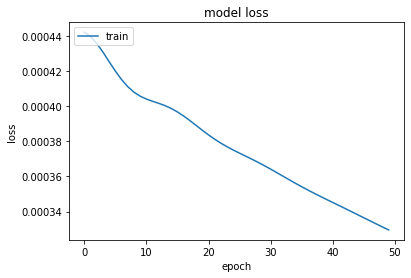

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(x)

pred

scale_y.inverse_transform(pred)



array([[31.372728],
       [45.06321 ],
       [59.33741 ],
       [73.849434],
       [98.333855]], dtype=float32)

You could try different learning rates, try removing layers, using scaling or not etc.